In [5]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import haversine as hs
from haversine import haversine, Unit
import random
import string
from datetime import datetime
from hurricaneModels import HurricaneModel
import xgboost as xgb
from sklearn import svm
from statsmodels.tsa.arima.model import ARIMA

## Pre-Processing

In [6]:
# Importing Data
data_folder = glob.glob('matToPyData/*.csv')
data_folder.sort()
data_list = []

for file in data_folder:
    print(file)
    df = pd.read_csv(file, header = None)
    df.drop(df.columns[3], inplace = True, axis = 1) # dropping fake numeric date
    data_list.append(df)



matToPyData/bestStormData_1.csv
matToPyData/bestStormData_2.csv
matToPyData/bestStormData_3.csv
matToPyData/bestStormData_4.csv
matToPyData/bestStormData_5.csv
matToPyData/bestStormData_6.csv
matToPyData/bestStormData_7.csv


In [7]:
# Importing Data Dates
dates_folder = glob.glob('matToPyDates/*.csv')
dates_folder.sort()
dates_list = []

for file in dates_folder:
    print(file)
    df = pd.read_csv(file, header = None)
    dates_list.append(df)

matToPyDates/bestStormDates_1.csv
matToPyDates/bestStormDates_2.csv
matToPyDates/bestStormDates_3.csv
matToPyDates/bestStormDates_4.csv
matToPyDates/bestStormDates_5.csv
matToPyDates/bestStormDates_6.csv
matToPyDates/bestStormDates_7.csv


### Feature Engineering

In [8]:
random.seed(10)
final_data_list = []
for i in range(0, len(dates_list)):
    df = pd.concat([data_list[i], dates_list[i]], axis = 1)
    df.columns = ['lat', 'long', 'distance', 'azimuth', 'speed', 'cp', 'windspeed', 
                  'landfall_flag', 'overland_flag', 'maxwind', 'min_cp','rad_maxwind', 'eye_diam', 'pressure_isobar', 'rad_isobar' ,'date_time']
    #print(df.shape)
    
    df = df[df['lat'].between(-90,90)] # removing impossible long lat values
    df = df[df['long'].between(-180,180)]
    
    #print(df.shape)

    df['SID'] = random.choice(string.ascii_uppercase) + '_' + str(i + 1) #assigning IDs

    df['date_time'] = pd.to_datetime(df['date_time']) # converting dates to timedate
    final_data_list.append(df)

In [9]:
def haversine(lat1, lat2, lon1, lon2):
    p1 = (lat1, lon1)
    p2 = (lat2, lon2)
    return hs.haversine(p1, p2)

# Adding between point distance as a feature
for data in final_data_list:
    data.loc[0, 'derived_distance'] = 0
    for i in range(1, len(data)):
        data.loc[i, 'derived_distance'] = haversine(data.iloc[i-1, :]['lat'], 
                                                     data.iloc[i, :]['lat'], 
                                                     data.iloc[i-1, :]['long'], 
                                                     data.iloc[i, :]['long'])

In [20]:
# Exporting all final preprocessed data:
k = 1
for data in final_data_list:
    data.to_csv('/Users/jasonluo/Documents/Hurricane_proj/finalPreprocData/final_dataset' + str(k) + '.csv', 
                index = False)
    k += 1

## Analysis

['S_1'] MSE: 8100.369214356356 MAE: 81.02827011276814 MAPE: 88.44927314988519
['B_2'] MSE: 2188.1128435139562 MAE: 35.083135245174105 MAPE: 27.332376594404153
['N_3'] MSE: 3773.77513495668 MAE: 54.37129565766161 MAPE: 42.241772887477964
['P_4'] MSE: 1763.775987837742 MAE: 39.705024820719245 MAPE: 25.423123033113832
['S_5'] MSE: 967.1392653005319 MAE: 26.706840105511624 MAPE: 23.926373443246028
['A_6'] MSE: 460.6689631642479 MAE: 16.46203647398605 MAPE: 13.205772417116096
['G_7'] MSE: 393.77122817835453 MAE: 16.370087798589925 MAPE: 16.657123073375


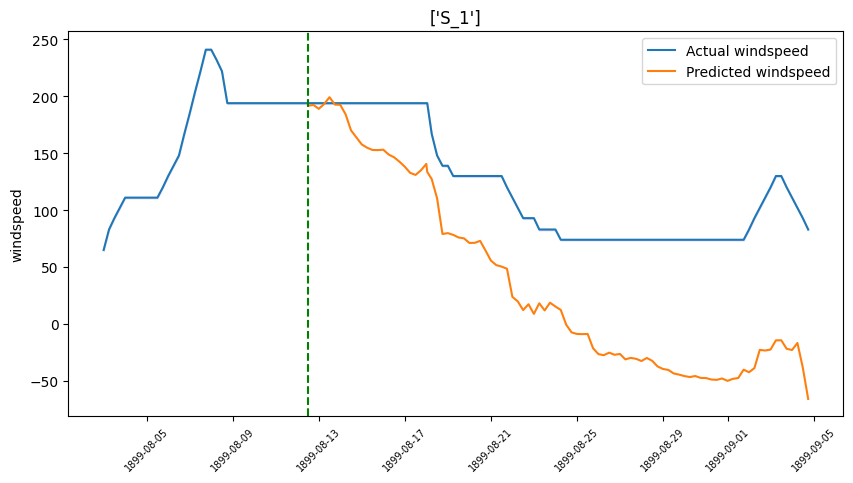

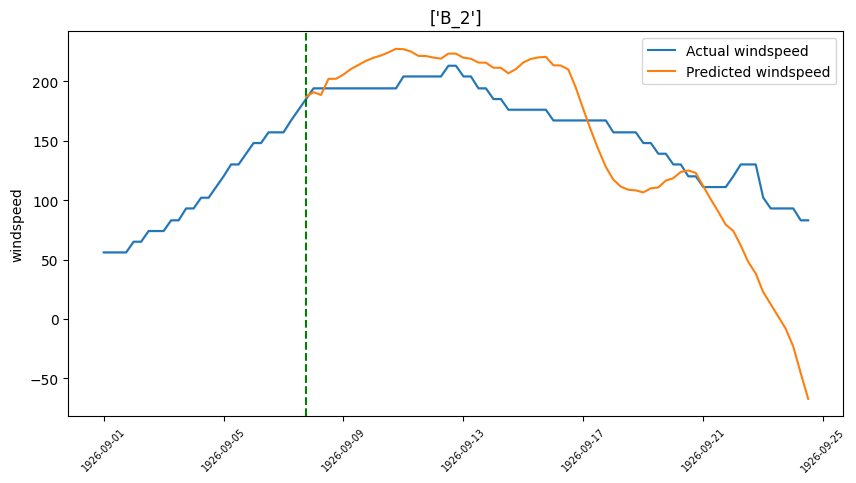

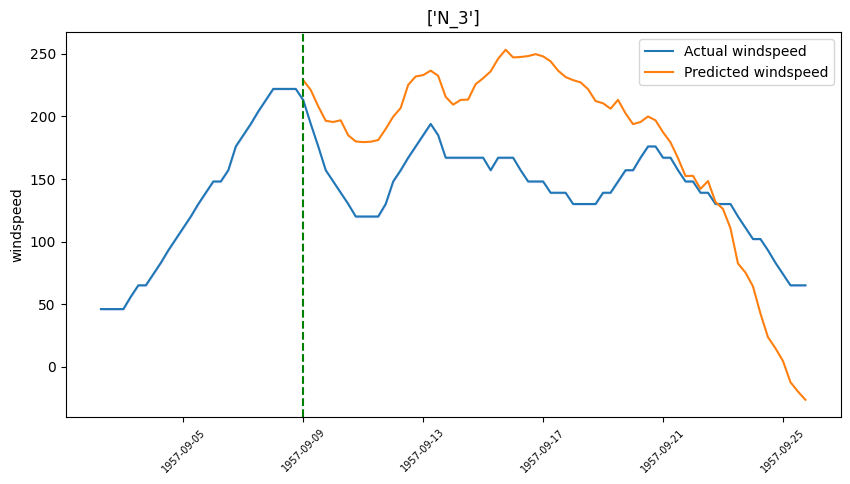

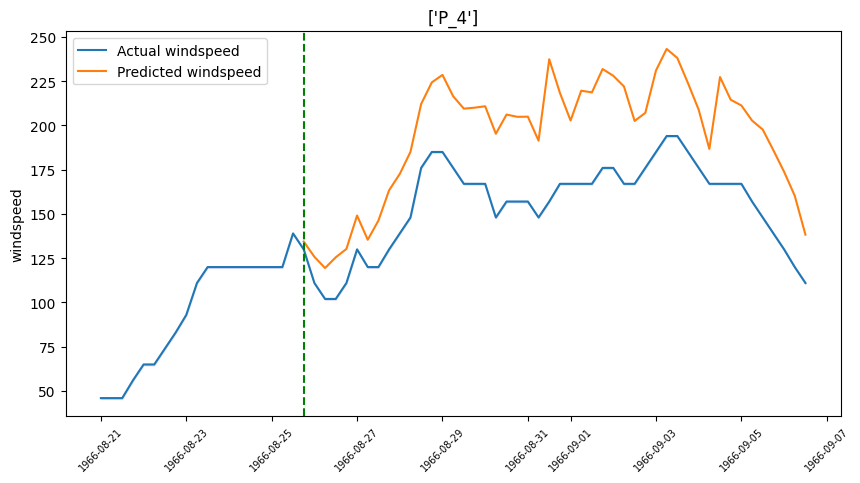

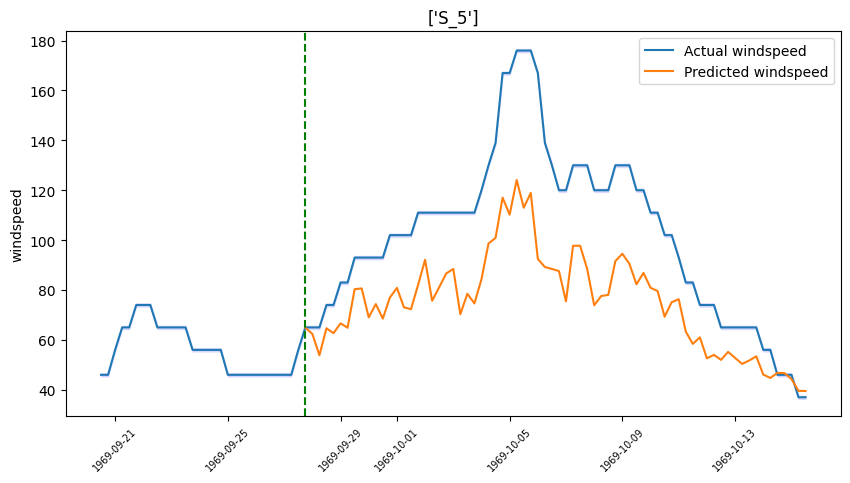

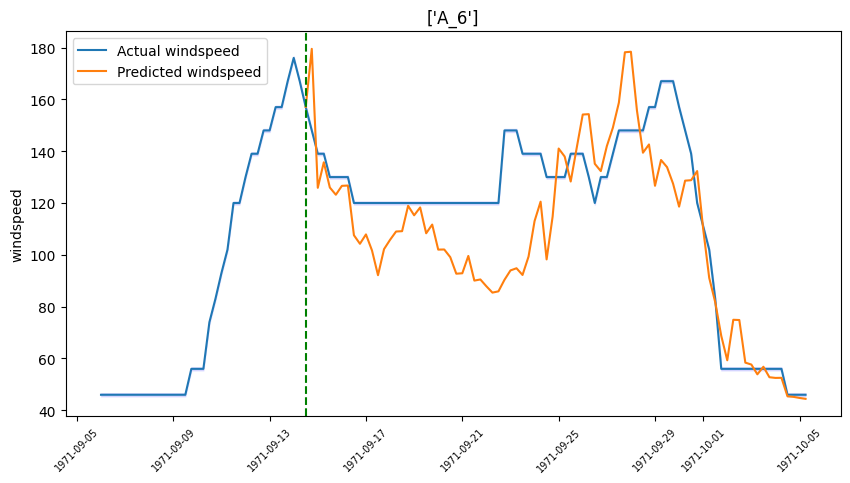

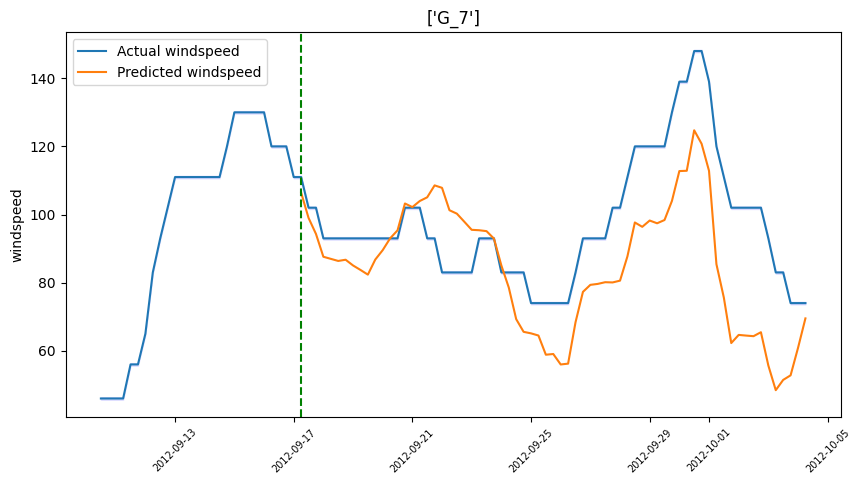

In [10]:
feats = ['lat', 'long', 'speed', 'cp', 'derived_distance']
target = 'windspeed'
ratio = 0.3

model1 = xgb.XGBRegressor(n_estimators = 100)
model2 = svm.SVR(kernel = 'linear')

for data in final_data_list:
    Hmodel = HurricaneModel(model2, data)
    Hmodel.split_train_predict(ratio, feats, target, True)
    #Hmodel.plotPACF(target)

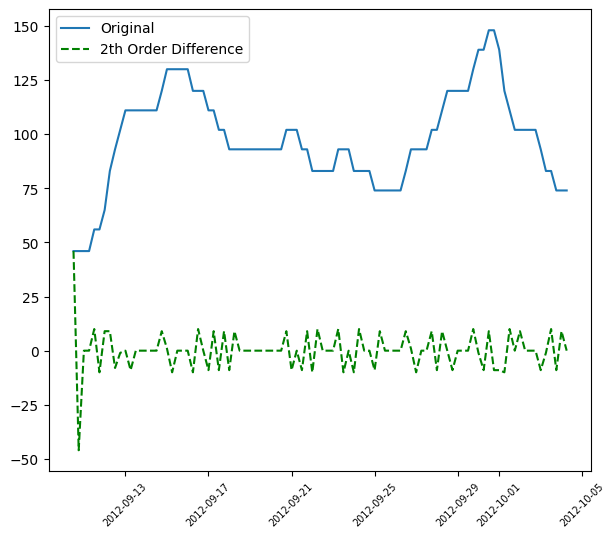

In [11]:
diffed_data = Hmodel.plotDiff('windspeed', order = 2)

In [16]:
model3 = ARIMA((1,1,1))
print(type(model3))

<class 'statsmodels.tsa.arima.model.ARIMA'>
<class 'xgboost.sklearn.XGBRegressor'>hi
